In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [2]:
ellipse_data = pd.read_csv("/content/drive/MyDrive/ESL Passion Project/ELLIPSE_Final_github_train.csv")
ellipse_data2 = pd.read_csv("/content/drive/MyDrive/ESL Passion Project/ELLIPSE_Final_github_test.csv")


print(len(ellipse_data) + len(ellipse_data2) )

6482


In [3]:
df = pd.concat([ellipse_data,ellipse_data2],ignore_index=True)

df.head()

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,set
0,5661280443,Imagine if you could prove other people that y...,Male,8,Hispanic/Latino,420,431,431,18,4,...,Economically disadvantaged,Benefits of a problem,4.0,3.5,4.0,3.5,3.5,4.0,4.0,train
1,0016926B079C,I think that students would benefit from learn...,Male,12,Black/African American,246,264,261,18,4,...,Economically disadvantaged,Distance learning,3.5,3.5,3.5,3.0,3.0,4.0,3.0,train
2,0022683E9EA5,When a problem is a change you have to let it ...,Female,8,Hispanic/Latino,513,536,533,14,6,...,Not economically disadvantaged,Benefits of a problem,2.5,2.5,2.5,3.0,2.0,2.0,2.5,train
3,00299B378633,"Dear, Principal\n\nIf u change the school poli...",Male,8,Hispanic/Latino,310,330,320,19,2,...,Economically disadvantaged,Grades for extracurricular activities,3.0,3.0,3.5,3.0,3.0,3.0,2.5,train
4,003885A45F42,The best time in life is when you become yours...,Male,12,White,734,757,728,36,8,...,Not economically disadvantaged,Individuality,4.5,4.5,4.5,4.5,4.5,4.0,5.0,train


In [4]:
essays = df["full_text"]

In [5]:
essays = essays.tolist()
print(essays[:2])

['Imagine if you could prove other people that you are a good problem solver. Imagine that a problem is a good chance to do your best because youre a good problem solver, and you can learn something from that problem. I think that problems are a good chance to show people that youre good at something, and that they can seek your help if they need to. I agree that a problem is a good chance to do your best because you can learn from that problem, and prove yourself that you can do it.\n\nYou can learn from your problems, and that it enhances your skills. Learning from your problems can help enhance your techniques for problem solving. Learning from your problems can help you on other problems you might have on future occasions. Getting good at problem solving can lead you to helping other is they need the help from or they dont really know what to do. When you are good at problem solving and you seek to get better problem solving becomes easy for you because you have been doing it for a

In [6]:
all_text = "\n".join(essays)

chars = sorted(list(set(all_text)))



In [7]:
# char_to_idx: Maps each character to a number
char_to_index = {c: i for i,c in enumerate(chars)}

#idx_to_char: Reverse mapping (number back to character)
index_to_char = {i: c for i,c in enumerate(chars)}

vocab_size = len(chars)
print(vocab_size)

104


In [8]:
print(vocab_size)
print("Char to Index Dictionary")
print(char_to_index)
print("Index to Char Dictionary")
print(index_to_char)



104
Char to Index Dictionary
{'\n': 0, '\r': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '<': 30, '=': 31, '>': 32, '?': 33, '@': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, '\\': 62, ']': 63, '_': 64, '`': 65, 'a': 66, 'b': 67, 'c': 68, 'd': 69, 'e': 70, 'f': 71, 'g': 72, 'h': 73, 'i': 74, 'j': 75, 'k': 76, 'l': 77, 'm': 78, 'n': 79, 'o': 80, 'p': 81, 'q': 82, 'r': 83, 's': 84, 't': 85, 'u': 86, 'v': 87, 'w': 88, 'x': 89, 'y': 90, 'z': 91, '{': 92, '|': 93, '}': 94, '~': 95, '\x80': 96, '\x82': 97, '\x9e': 98, 'º': 99, 'Â': 100, 'Ã': 101, 'Ê': 102, 'â': 103}
Index to Char Dictionary
{0:

In [9]:
#@title data is ALL of the text converted to encoded numeric form for the purpose of training -> numpy array format
data = np.array([char_to_index[ch] for ch in all_text])


sequence_length = 60

print(f"total characters in dataset: {len(data)}")


X = []
y = []

for i in range(len(data) - sequence_length):
  X.append(data[i:i+sequence_length])
  y.append(data[i + sequence_length])

X = np.array(X)
y = np.array(y)

#building train, val, test data
num_samples = len(X)
train_val_split = int(0.90*num_samples)
val_test_split = int(0.98*num_samples)


X_train = X[:train_val_split]
y_train = y[:train_val_split]

X_val = X[train_val_split:val_test_split]
y_val = y[train_val_split:val_test_split]

X_test = X[val_test_split:]
y_test = y[val_test_split:]





total characters in dataset: 15042208


In [10]:

#@title One-hot encode
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, vocab_size):
        self.X = X          # integer indices, shape (N, seq_len)
        self.y = y          # integer targets, shape (N,)
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx]                  # (seq_len,)
        one_hot = np.zeros((len(seq), self.vocab_size), dtype=np.float32)

        one_hot[np.arange(len(seq)), seq] = 1.0
        x_tensor = torch.from_numpy(one_hot)      # (seq_len, vocab_size)
        y_tensor = torch.tensor(self.y[idx]).long()
        return x_tensor, y_tensor



In [11]:
# @title building the LSTM


class CharRNN(nn.Module):
  def __init__(self, vocab_size, hidden_size=256,num_layers=2,dropout = 0.3):
    super(CharRNN, self).__init__()

    self.lstm = nn.LSTM(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first = True,
        dropout = dropout if num_layers > 1 else 0
        )

    self.fc = nn.Linear(hidden_size,vocab_size)


  def forward(self,x):
    lstm_out, (h,c) = self.lstm(x)

    last_output = lstm_out[:,-1,:]
    logits = self.fc(last_output)
    return logits


In [12]:
#@title Making our trained model generate text
def generate_text(my_model, starting_text, length=200,
                  sequence_length=60, temperature=1.0, device="cuda"):
    my_model.eval()
    encoded = [char_to_index.get(ch, 0) for ch in starting_text]

    if len(encoded) < sequence_length:
        encoded = [0] * (sequence_length - len(encoded)) + encoded
    encoded = encoded[-sequence_length:]

    generated = starting_text

    with torch.no_grad():
        for _ in range(length):
            x = np.zeros((1, sequence_length, vocab_size), dtype=np.float32)
            x[0, np.arange(sequence_length), encoded[-sequence_length:]] = 1.0
            x = torch.from_numpy(x).to(device)

            logits = my_model(x) / temperature
            probs = torch.softmax(logits, dim=1)
            next_idx = torch.multinomial(probs, 1).item()
            next_char = index_to_char[next_idx]

            generated += next_char
            encoded.append(next_idx)

    return generated


In [13]:
# @title Creating batches & loading them
batch_size = 256

train_dataset = CharDataset(X_train, y_train, vocab_size)
val_dataset   = CharDataset(X_val,   y_val,   vocab_size)
test_dataset  = CharDataset(X_test,  y_test,  vocab_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
test_loader  = DataLoader(test_dataset,  batch_size=512)


In [ ]:
# @title Training the Model and storing Train/Val Loss (DONE)


# define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(),lr=0.001)

num_epochs =10
starting_epoch=20

# Training
for epoch in range(num_epochs):

  my_model.train()
  train_loss=0

  for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    logits = my_model(X_batch)
    loss = criterion(logits,y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss+= loss.item()

  train_loss/= len(train_loader)
  train_losses.append(train_loss)


  my_model.eval()
  val_loss = 0

  with torch.no_grad():
    for X_batch, y_batch in val_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      logits = my_model(X_batch)
      loss = criterion(logits,y_batch)

      val_loss+= loss.item()

    val_loss/=len(val_loader)
    val_losses.append(val_loss)

  if (epoch + 1) % 5 == 0:
    torch.save(my_model.state_dict(), '/content/drive/MyDrive/ESL Passion Project/checkpoint_epoch_{}.pth'.format(epoch+1))
    print(f"Checkpoint saved at epoch {starting_epoch+epoch+1}")
    sample = generate_text(my_model, "The government is",
                           length=150,
                           sequence_length=sequence_length,
                           temperature=0.8,
                           device=device)
    print(sample[:300])



  print(f"Epoch {starting_epoch + epoch+1}/{starting_epoch + num_epochs} - Train Loss: {train_loss:.4f}, Val loss: {val_loss:.4f} ")




Epoch 21/30 - Train Loss: 0.9175, Val loss: 0.9037 
Epoch 22/30 - Train Loss: 0.9166, Val loss: 0.9019 
Epoch 23/30 - Train Loss: 0.9163, Val loss: 0.9025 
Epoch 24/30 - Train Loss: 0.9182, Val loss: 0.9041 
Checkpoint saved at epoch 25
The government isn't a great for people to have more time to do other activities. They can learn about subjects. For example, some students will not want to lose the o
Epoch 25/30 - Train Loss: 0.9193, Val loss: 0.9041 
Epoch 26/30 - Train Loss: 0.9201, Val loss: 0.9056 
Epoch 27/30 - Train Loss: 0.9196, Val loss: 0.9050 
Epoch 28/30 - Train Loss: 0.9207, Val loss: 0.9098 
Epoch 29/30 - Train Loss: 0.9303, Val loss: 0.9146 
Checkpoint saved at epoch 30
The government is when to grow at school with a group work, however, if we have a positive attitude is a chance for students to do not be all the person or someone tha
Epoch 30/30 - Train Loss: 0.9593, Val loss: 0.9339 


In [ ]:
#@title The model will start from these losses
print(f"Previous Train loss: {train_losses[-1]:.4f}")

print(f"Previous Validation loss: {(val_losses[-1]):.4f}")

Previous Train loss: 0.9183
Previous Validation loss: 0.9046


In [ ]:
print(f"Previous Train loss: {train_losses}")

print(f"Previous Validation loss: {val_losses}")

Previous Train loss: [1.191827827833258, 1.0259141290897686, 0.9942914704688772, 0.977409456506037, 0.9661796850468625, 0.9579836141954262, 0.9516230600764725, 0.9462322427997759, 0.9418346498188958, 0.9382635805747189, 0.9350328528964253, 0.9322710541103322, 0.9299456987833536, 0.9277023875113504, 0.9257865410739864, 0.924200384809767, 0.9225100706905955, 0.9210047700763405, 0.9195001637345261, 0.918294842862696, 0.9174975308052695, 0.9165573000553987, 0.9162544298974045, 0.9182239647043087, 0.9193458333331122, 0.9201092494306605, 0.9195743171694402, 0.9206564945239396, 0.9303033234284883, 0.9593084058370627]
Previous Validation loss: [1.022287151389986, 0.9792848169726653, 0.9598821365770065, 0.9470792401810227, 0.9378389522856349, 0.9335671374816495, 0.9286580608695685, 0.9255840218272532, 0.9214692554600858, 0.9189599207433056, 0.9163879278973058, 0.9146488436491904, 0.9136232958818906, 0.9104847152102968, 0.9090194066249863, 0.9102163210219885, 0.9066321071755585, 0.90493843937592

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


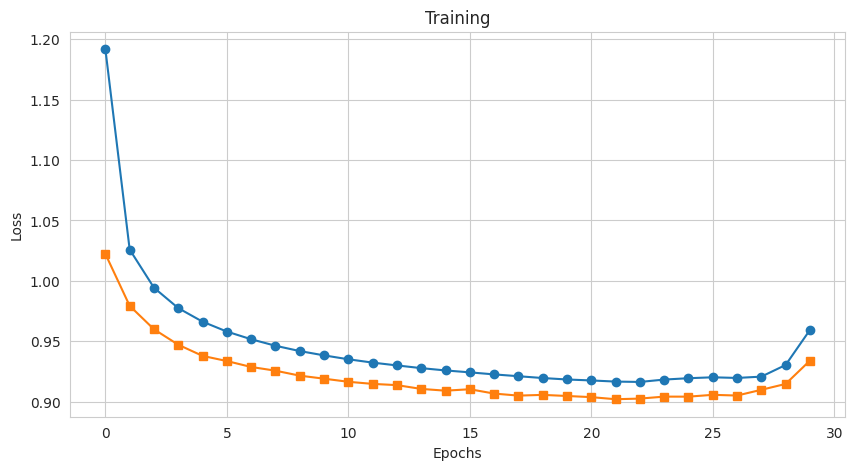

<Axes: >

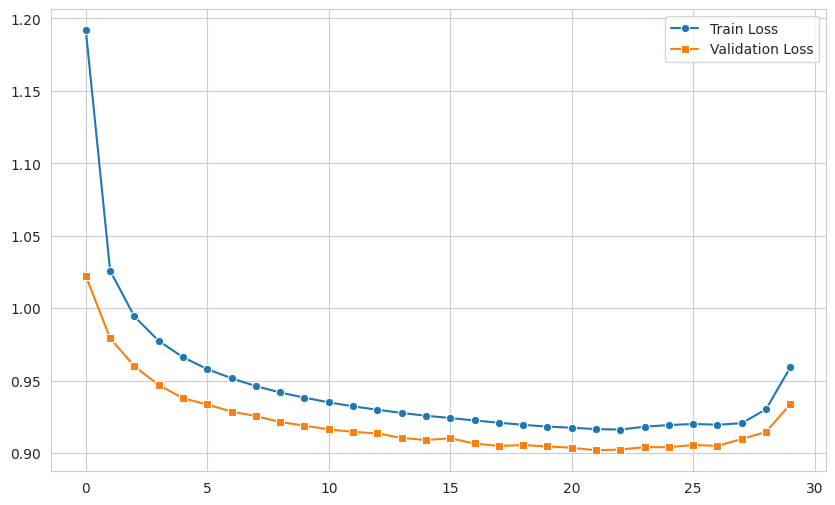

In [ ]:
# @title Plots (DONT TOUCH)
# plot training & validation loss

epochs=np.arange(30)
print(epochs)

plt.figure(figsize=(10,5))
plt.plot(epochs,train_losses,label='Train Loss', marker = 'o')
plt.plot(epochs,val_losses,label = 'Validation Loss',marker='s' )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training")
plt.grid(True)
plt.show()


sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(x=epochs,y=train_losses, label='Train Loss', marker = 'o')
sns.lineplot(x=epochs,y=val_losses,label = 'Validation Loss',marker='s' )


In [14]:
# @title Loading the Saved Parameters in


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = CharRNN(vocab_size).to(device)
mid_model = CharRNN(vocab_size).to(device)

#best model is EPOCH 20
best_state_dict = torch.load("/content/drive/MyDrive/ESL Passion Project/checkpoint_epoch_5.pth")
best_model.load_state_dict(best_state_dict)

#mid model is EPOCH 15
mid_model_dict = torch.load("/content/drive/MyDrive/ESL Passion Project/checkpoint_epoch_15.pth")
mid_model.load_state_dict(mid_model_dict)

print("loaded model again")




loaded model again


In [15]:
# @title Test Accuracy: best_model got 72.8% accuracy
#Accuracy: 63% initial, 72% after 30 epochs, (~73% accuracy) 72.8% after 20 epochs, 72.7% after 15 epochs, ~72% after 10 epochs

# X_test_tensor | y_test_tensor

best_model.eval()
all_preds = []

with torch.no_grad():
  for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    pred = best_model(X_batch)
    all_preds.append(pred)


all_preds = torch.cat(all_preds)
#argmax finds the index of the largest value from the predictions tensor
predictions = torch.argmax(all_preds,dim=1)

total_correct = (predictions == torch.tensor(y_test).to(device)).sum()
accuracy = total_correct.float() / len(y_test)
print("Test accuracy:", accuracy.item())


Test accuracy: 0.7285527586936951


Your mom is a career at school is that your body npw will others that they want. I would be hoact their linesation abrt. Ar is about the money bacioi ayshed on and should gate because if they can fot and Gsinyir


In [ ]:
prompts = [
    "Most schools let students",
    "I am",
    "Today is",
    "School",
    "Your mom"


]

for prompt in prompts:
    output = generate_text(best_model, prompt, length=150,
                           sequence_length=sequence_length,
                           temperature=0.8,
                           device=device)

    midput = generate_text(mid_model, prompt, length=150,
                           sequence_length=sequence_length,
                           temperature=0.8,
                           device=device)


    print("\n" + "="*70)
    print(f"Prompt: '{prompt}'")
    print("="*70)
    print("Best model: ",output)
    print("Mid model: ",midput)






Prompt: 'Most schools let students'
Best model:  Most schools let students understand more about what they are going to do. Students can even be discover what they want in the future and you can attend it.

You can accomplis
Mid model:  Most schools let students learn something they parents can work and they dont know what to do.

Schools should cause as Saln relining because you are so many of them that they

Prompt: 'I am'
Best model:  I am agree with the school should be praise to remember that people know what they are passing, but this program are better for them to prosted. Having th
Mid model:  I am my parents or simple capacity and works and being a say when they are. the teacher gave the students the amazing advantages that students have to do 

Prompt: 'Today is'
Best model:  Today is Marrise I like somthing in the future but i tried more praised enghanist and my mom, but I dont want to be a point, it will always preperent the posi
Mid model:  Today is a good version as well

In [ ]:
#train_losses, val_losses = [], []
print(train_losses)

[1.191827827833258, 1.0259141290897686, 0.9942914704688772, 0.977409456506037, 0.9661796850468625, 0.9579836141954262, 0.9516230600764725, 0.9462322427997759, 0.9418346498188958, 0.9382635805747189, 0.9350328528964253, 0.9322710541103322, 0.9299456987833536, 0.9277023875113504, 0.9257865410739864]


In [16]:
# @title Sampled 5 ESL prompts with 20 responses to each, total 100
import random
esl_model = best_model

n_per_prompt = 20
rows = []

print(df["prompt"].value_counts()[:5])
print("-"*70)
prompts = ["Distance learning",
           "Success and failure",
           "Career commitment",
           "Being busy",
           "Impact of technology"]

for prompt in prompts:
  subset = df[df["prompt"]==prompt]

  sample = subset.sample(n=min(n_per_prompt,len(subset)),random_state=42)

  for _, row in sample.iterrows():
    rows.append({"prompt": prompt, "full_text": row["full_text"],"source": "human_esl"})

esl_real = pd.DataFrame(rows)
print(esl_real.head())
print(len(esl_real),"sampled essays")

esl_real.to_csv("esl_real_sampled.csv",index=False)

prompt
Distance learning       489
Success and failure     379
Career commitment       367
Being busy              341
Impact of technology    301
Name: count, dtype: int64
----------------------------------------------------------------------
              prompt                                          full_text  \
0  Distance learning  Students who attend school online from home ha...   
1  Distance learning  Some people say that students are better off a...   
2  Distance learning  Some schools offer distance learning as an opt...   
3  Distance learning  I think that could be a good idea attend class...   
4  Distance learning  Distance school learning\n\nDisatance learning...   

      source  
0  human_esl  
1  human_esl  
2  human_esl  
3  human_esl  
4  human_esl  
100 sampled essays


In [17]:
# @title Perplexity Score
first_essay_text = esl_real["full_text"].iloc[0]

from torch.nn.functional import log_softmax


def compute_complexity(text, model, char_to_index, vocab_size, sequence_length=60,device=device):
  indices = [char_to_index.get(ch,0) for ch in text]

  if len(indices) <= sequence_length:
    print(f"Warning: text too short ({len(indices)} chars)")
    return float("inf"), float("inf"),0

  total_nll = 0.0
  num_predictions = 0

  for t in range(sequence_length,len(indices)):
    context = indices[t-sequence_length:t]
    target = indices[t]

    x = np.zeros((1,sequence_length,vocab_size),dtype=np.float32)

    for i, index in enumerate(context):
      x[0,i,index] = 1.0

    x_tensor = torch.from_numpy(x).to(device)

    logits = model(x_tensor)

    log_probs = log_softmax(logits,dim=1)

    nll = -log_probs[0,target].item()
    total_nll += nll
    num_predictions +=1

  avg_nll = total_nll/num_predictions
  perplexity = np.exp(avg_nll)

  return perplexity, avg_nll, num_predictions



In [18]:
ppl, nll, n_chars = compute_complexity(
    first_essay_text,
    esl_model,
    char_to_index,
    vocab_size,
    sequence_length=60,
    device=device,
)

print("Perplexity:", ppl)
print("Avg NLL:", nll)
print("Num predictions:", n_chars)
print("Preview:", first_essay_text[:])


Perplexity: 2.3743172661240624
Avg NLL: 0.8647099292649447
Num predictions: 2222
Preview: Students who attend school online from home have possible advantages to complete work with time and can study easier. Another possible way that students can learn from home is having a good friend by your side and always telling you to not give up and pay attention to what the teacher is explaining to the class.

Disadvantages of online home school are the completion of the notes everyday to keep up with they topic the teacher is going with the class; you might get distracted with your phone or do something that is not paying attention to the teacher while they're explaining the topic of the day. And I really think that students should just go to normal school and learn the way everybody learns

Another dis-benefit attending classes from home is one , the student might not even pay attention or even write down the notes the teacher is going over with the class. They could get easily distracted by 

In [ ]:
#@title Running Perplexity Score for our ESL Data

# Perplexity is a measure of similarity in a way, we expect low perplexity between esl_model and ESL data since it's easily predictable.
# We expect high perplexity between esl_model and AI-generated writing, and mid perplexity for esl_model and native-ai writing

# low NLL -> confident, high NLL -> not confident

perplexities = []
avg_nll = []
num_chars_list = []

for idx, row in esl_real.iterrows():
  text = row["full_text"]

  p,n,l = compute_complexity(
      text,
      esl_model,
      char_to_index,
      vocab_size,
      60,
      device
  )

  perplexities.append(p)
  avg_nll.append(n)
  num_chars_list.append(l)

esl_real["perplexity"] = perplexities
esl_real["avg_nll"] = avg_nll
esl_real["num_chars_used"] = num_chars_list


In [21]:

print(esl_real[["prompt","perplexity"]])

print(esl_real["perplexity"].describe())


KeyError: "['perplexity'] not in index"

In [22]:
# all 5 prompts
prompts_for_experiment = esl_real["prompt"].unique().tolist()

print(prompts_for_experiment)


# both ai prompts
native_ai_prompt = "Write a 400‑word persuasive essay responding to the following prompt as a fluent, native English‑speaking high school student. Use varied vocabulary and complex sentence structures:"
esl_ai_prompt = "Write a 400‑word persuasive essay responding to the following prompt as a B1‑level ESL high school student. Use simpler vocabulary, some grammar mistakes, and repetitive sentence structures, but keep the meaning clear: "

['Distance learning', 'Success and failure', 'Career commitment', 'Being busy', 'Impact of technology']


In [23]:
# @title This Handcrafts any prompts
def make_prompt(prompt_text, type):
  if type == "native":
    return (f"Write a 400‑word persuasive essay responding to the following prompt as a fluent, native English‑speaking high school student. Use varied vocabulary and complex sentence structures: \n \n {prompt_text}")
  elif type == "esl":
    return (f"Write a 400‑word persuasive essay responding to the following prompt as a B1‑level ESL high school student. Use simpler vocabulary, some grammar mistakes, and repetitive sentence structures, but keep the meaning clear: \n \n {prompt_text}")
  else:
    raise ValueError("style must be 'native' or 'esl'")



In [31]:
import openai, time
from google.colab import userdata

api_key = userdata.get('openai_key')

client = openai.OpenAI(api_key=api_key)

# for i in range(len(prompts_for_experiments)):
#.   for n in range(20):
prompt1 = make_prompt(prompts_for_experiment[0],"native")
print(prompt1)

# function that generates AI essay w/ API call
def generate_essay(prompt,type,model,temperature=0.8):
  prompt_for_ai = make_prompt(prompt,type)

  messages = [
      {"role":"system", "content": "You are a helpful writing tutor who writes persuasive high school essays following the user’s instructions"},
      {"role":"user","content":prompt_for_ai}
  ]

  response = client.chat.completions.create(model=model,messages=messages,temperature=temperature)

  essay_text = response.choices[0].message.content

  return essay_text






Write a 400‑word persuasive essay responding to the following prompt as a fluent, native English‑speaking high school student. Use varied vocabulary and complex sentence structures: 
 
 Distance learning


In [32]:
#@title Test: AI Generated Native Essay on "Distance Learning" Prompt
native_ai_essay = generate_essay(prompt1,"native",model="gpt-4.1")

print(native_ai_essay)

In recent years, distance learning has become an increasingly prevalent mode of education, especially since the COVID-19 pandemic forced schools worldwide to adapt rapidly. Some critics argue that remote education cannot replace the dynamic environment of in-person classrooms, citing issues such as lack of social interaction and potential distractions at home. However, I firmly believe that distance learning, when implemented thoughtfully, offers significant advantages that not only rival but, in some cases, surpass those of traditional education.

First and foremost, distance learning provides unparalleled flexibility, allowing students to tailor their learning experience to their unique needs. Traditional classroom settings often adopt a one-size-fits-all approach, which may overlook individual learning styles. With online education, students can pause, rewind, or rewatch lectures, access supplemental materials at their own pace, and review challenging concepts until they fully under

In [33]:
#@title Test: AI Generated ESL on "Distance Learning" Prompt
esl_ai_essay = generate_essay(prompt1,"esl",model="gpt-4.1")

print(esl_ai_essay)

Distance learning is a new way of education that is becoming better and better every year. I believe that distance learning is a good idea for many students. In my essay, I will explain why distance learning is useful, why it helps people learn, and why it is good for different people.

First, distance learning is very useful because students can learn from home. It is easy to use a computer or a phone to join online classes. Students do not need to wake up very early and go to school by bus or by car. They can just stay at home and learn in their own room. This can help students save time and not get tired from travel. If students feel comfortable at home, they can pay more attention to lessons and do better in school.

Second, distance learning helps people learn at their own speed. In normal school, sometimes teachers go too fast or too slow. In distance learning, students can watch lessons again if they do not understand. They can also do homework when they have time. Some students

In [ ]:
'''
Feb 7- Today I made the function to generate an AI essay. Now, what's next? We need to generate native AISAs for all five prompts, 20 times, for a total of 100. Then, do that same thing for ESL and compute complexity scores or perplexity scores.
'''